# Importing packages for my tree models

In [24]:
# Importing the packages to prepare the mdoel and execute it...
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import shap

plt.rcParams["figure.figsize"] = (6, 4)

# Loading the case-only dataset
This cell reads the same cleaned dataset you used before.

In [2]:
# Loading all the dataset again and creatign datafile
currentpath = Path.cwd()

# baseTablePath = Path("C:/STS/My Project/StressMetastasis/Aim1/data/analysis_base_clean.csv")
df = pd.read_csv(f'{currentpath.parent}/data/analysis_base_clean.csv')
print(df.columns.tolist())
print("Loaded shape:", df.shape)

['seqn', 'age_years', 'age_group', 'sex', 'race_eth', 'educ_level', 'pir', 'mcq220', 'ever_cancer', 'dpq_total', 'dpq_cat', 'smoke_status', 'hscrp_mg_l_raw', 'hscrp_cat', 'bmx_bmi', 'bmx_weight_kg', 'bmx_height_cm', 'bmx_waist_cm', 'bmx_hip_cm', 'dpq_severity', 'hscrp_flag_acute']
Loaded shape: (7800, 21)


# Selecting cancer cases only and creating the early vs late target

In [47]:
# I was getting an error in the model, so I changed the type to integer 
if "ever_cancer" in df.columns:
    outcome_col = "ever_cancer"
    df[outcome_col] = pd.to_numeric(df[outcome_col], errors="coerce").astype("Int64")
elif "mcq220" in df.columns:
    outcome_col = "mcq220"
    tmp = pd.to_numeric(df[outcome_col], errors="coerce").map({1: 1, 2: 0})
    df[outcome_col] = tmp.astype("Int64")
else:
    raise ValueError("Need a cancer indicator column.")

if "early_onset_proxy" not in df.columns:
    df["early_onset_proxy"] = (pd.to_numeric(df["age_years"], errors="coerce") < 50).astype(int)

cases = df[pd.to_numeric(df[outcome_col], errors="coerce") == 1].copy()
TARGET_COL = "early_onset_proxy"
print("Case-only shape:", cases.shape)

Case-only shape: (1169, 22)


# relevant variables

In [48]:
# make a copy of cases so we can add engineered columns
cases = cases.copy()

# create log CRP if raw CRP exists
if "hscrp_mg_l_raw" in cases.columns:
    cases["log_hscrp"] = np.log1p(cases["hscrp_mg_l_raw"])  # log(1+x) to avoid log(0)
else:
    cases["log_hscrp"] = np.nan

# numeric features that EXIST in your df
num_features = [c for c in [
    "dpq_total",      # depression score
    "log_hscrp",      # hscrp_mg_l_raw
    "pir",            # income ratio
    "age_years",
    "bmx_bmi"         # BMI column
] if c in cases.columns]

# categorical features that EXIST
cat_features = [c for c in [
    "smoke_status",
    "sex",
    "educ_level",
    "race_eth"
] if c in cases.columns]

# build encoded dataframe
cases_enc = pd.get_dummies(
    cases[num_features + cat_features + [TARGET_COL]],
    drop_first=True
)

X = cases_enc.drop(columns=[TARGET_COL])
y = cases_enc[TARGET_COL]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)

Numeric features: ['dpq_total', 'log_hscrp', 'pir', 'age_years', 'bmx_bmi']
Categorical features: ['smoke_status', 'sex', 'educ_level', 'race_eth']
Final X shape: (1169, 10)
Final y shape: (1169,)


# Splits the dataset for training and evaluation.

In [ ]:
X.drop(columns='age_years', inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (818, 9) Test: (351, 9)


# fiting the Random Forest model

In [10]:
# Random forest model :-)
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("Random Forest trained.")

Random Forest trained.


# fFts the XGBoost model with the parameters your professor suggested.

In [11]:
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=1.0,
    colsample_bytree=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
)
xgb_model.fit(X_train, y_train)
print("XGBoost trained.")

XGBoost trained.


# accuracy/AUC and saving ROC plots for both models

Random Forest Accuracy: 0.923
Random Forest AUC: 0.652


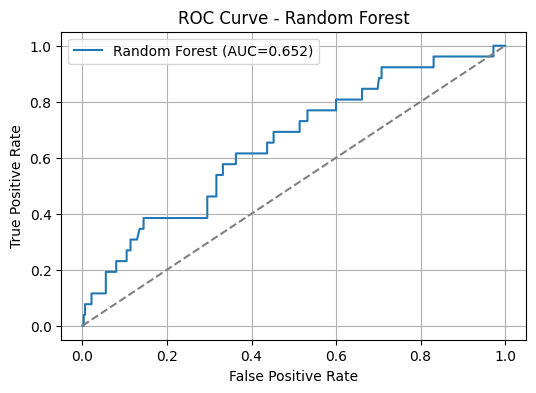

Saved ROC to roc_random_forest.png
XGBoost Accuracy: 0.915
XGBoost AUC: 0.557


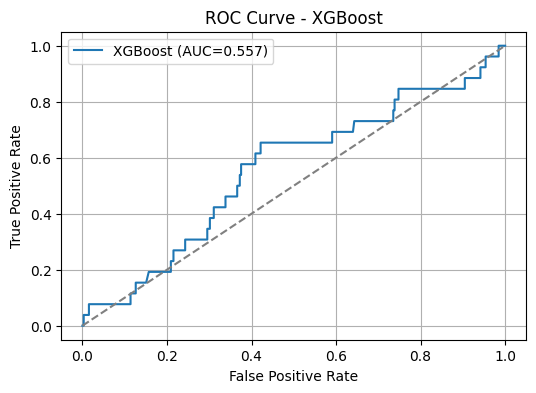

Saved ROC to roc_xgboost.png


In [12]:
def evaluate_model(model, X_test, y_test, model_name="model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"{model_name} Accuracy: {acc:.3f}")
    print(f"{model_name} AUC: {auc:.3f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    fname = f"roc_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved ROC to", fname)

evaluate_model(rf, X_test, y_test, model_name="Random Forest")
evaluate_model(xgb_model, X_test, y_test, model_name="XGBoost")

#  variables which contributed the most.

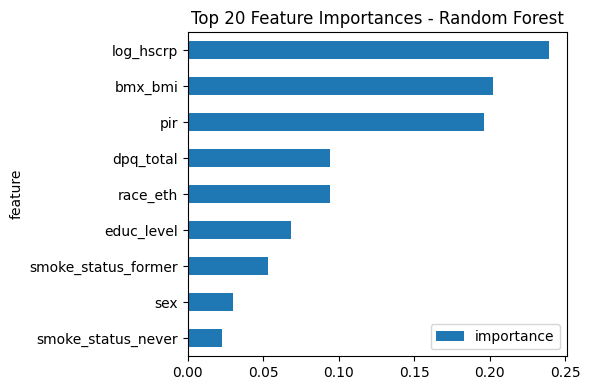

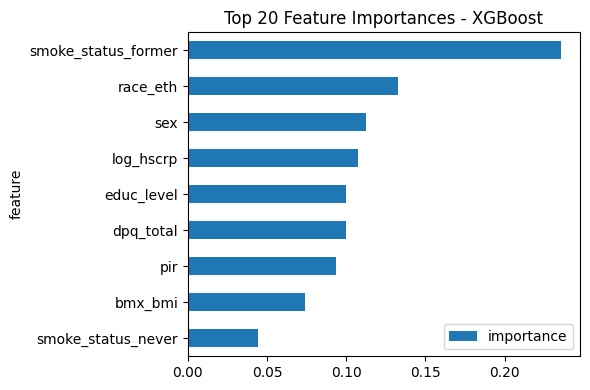

In [13]:
def plot_feature_importance(importances, feature_names, model_name="model", top_n=20):
    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).head(top_n)

    fi.plot(kind="barh", x="feature", y="importance")
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()
    return fi

rf_fi = plot_feature_importance(rf.feature_importances_, X_train.columns, model_name="Random Forest")
xgb_fi = plot_feature_importance(xgb_model.feature_importances_, X_train.columns, model_name="XGBoost")

# SHAP for XGBoost

ExactExplainer explainer: 819it [00:42, 19.14it/s]                         


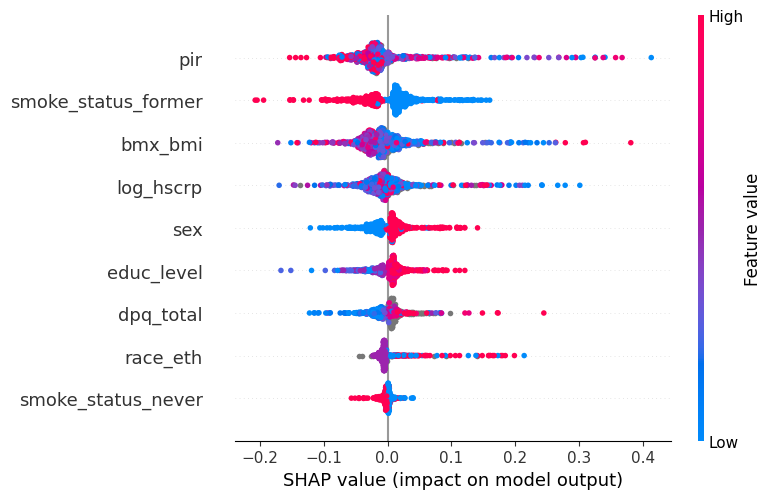

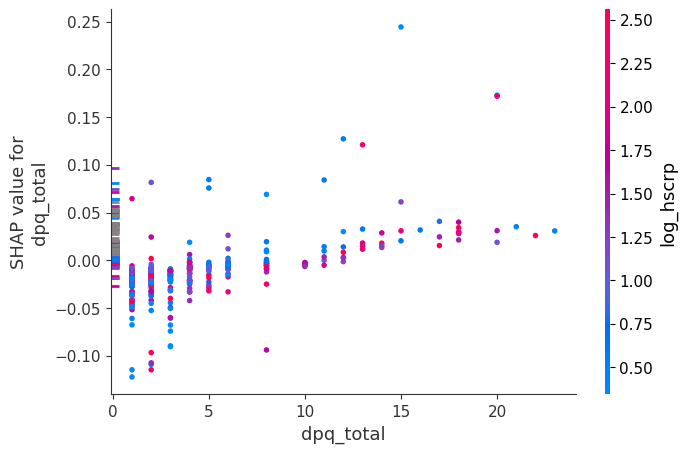

In [14]:
X_train_num = X_train.astype(float)
X_test_num = X_test.astype(float)

background = X_train_num.sample(200, random_state=42)

predict_fn = lambda X: xgb_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(predict_fn, background)
shap_values = explainer(X_train_num)

shap.summary_plot(shap_values.values, X_train_num, show=False)
plt.savefig("shap_summary_xgboost.png", dpi=150, bbox_inches="tight")
plt.show()

PHQ_COL = "dpq_total"
if PHQ_COL in X_train_num.columns:
    shap.dependence_plot(PHQ_COL, shap_values.values, X_train_num, show=False)
    plt.savefig("shap_dependence_dpq_total_std.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print(f"{PHQ_COL} not found in columns.")

dpq_cat ['none-minimal' 'mild' nan 'moderate' 'mod-severe' 'severe']
smoke_status ['former' 'never' 'current' nan]
hscrp_cat ['average' 'high' 'low' nan]
dpq_severity ['None-minimal' 'Mild' nan 'Moderate' 'Severe']


### Mukesh Updated code to check

In [49]:
noncases = df[df['ever_cancer']==0]
cases.drop(columns=['bmx_weight_kg','bmx_height_cm', 'bmx_waist_cm', 'bmx_hip_cm'], inplace = True)

In [50]:

cases['stress_high'] = cases['dpq_cat'].isin(['moderate','mod-severe','severe']).astype(int)

pd.crosstab(cases['early_onset_proxy'], cases['stress_high'], normalize='index')


stress_high,0,1
early_onset_proxy,,
0,0.930684,0.069316
1,0.896552,0.103448


In [51]:
noncases['stress_high'] = noncases['dpq_cat'].isin(['moderate','mod-severe','severe']).astype(int)
pd.crosstab(noncases['early_onset_proxy'], noncases['stress_high'], normalize='index')

C:\Users\TMHMXM447\AppData\Local\Temp\ipykernel_21948\1311609723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noncases['stress_high'] = noncases['dpq_cat'].isin(['moderate','mod-severe','severe']).astype(int)


stress_high,0,1
early_onset_proxy,,
0,0.928452,0.071548
1,0.894702,0.105298


C:\Users\TMHMXM447\AppData\Local\Temp\ipykernel_21948\1167535741.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='early_onset_proxy', y='stress_high', data=cases, ci=95)


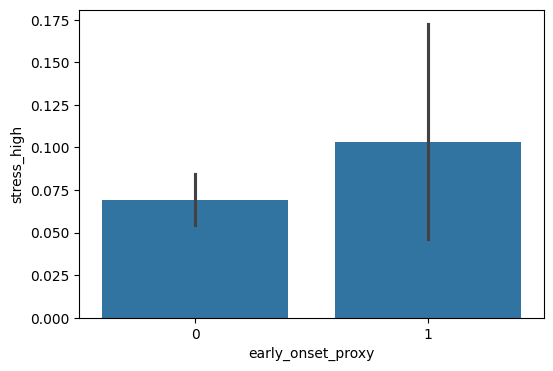

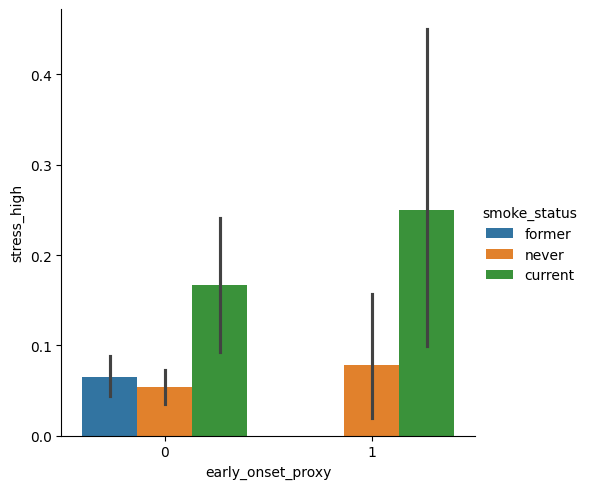

In [52]:
sns.barplot(x='early_onset_proxy', y='stress_high', data=cases, ci=95)
sns.catplot(x='early_onset_proxy', y='stress_high', hue='smoke_status', data=cases, kind='bar')


In [53]:

cases = cases[cases['hscrp_flag_acute'] != 1]
X = cases[['sex','race_eth','educ_level','pir','smoke_status','bmx_bmi','log_hscrp','hscrp_cat','early_onset_proxy']]
y = cases['stress_high']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(774, 9) (332, 9)


In [56]:
X_train.columns

Index(['sex', 'race_eth', 'educ_level', 'pir', 'smoke_status', 'bmx_bmi',
       'log_hscrp', 'hscrp_cat', 'early_onset_proxy'],
      dtype='object')

In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_cols = ['pir', 'bmx_bmi', 'log_hscrp', 'early_onset_proxy','sex','race_eth','educ_level']
cat_cols = ['smoke_status', 'hscrp_cat']

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

In [64]:
preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['pir', 'bmx_bmi', 'log_hscrp',
                                  'early_onset_proxy', 'sex', 'race_eth',
                                  'educ_level']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['smoke_status', 'hscrp_cat'])])

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=500,
        max_depth=6,
        random_state=42,
        class_weight='balanced'
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print("AUC:", roc_auc_score(y_test, y_proba_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
AUC: 0.6932601660334882
Accuracy: 0.8674698795180723
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       309
           1       0.00      0.00      0.00        23

    accuracy                           0.87       332
   macro avg       0.46      0.47      0.46       332
weighted avg       0.86      0.87      0.86       332



In [66]:
xgb = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost ===")
print("AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


=== XGBoost ===
AUC: 0.6693400872379344
Accuracy: 0.9066265060240963
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       309
           1       0.00      0.00      0.00        23

    accuracy                           0.91       332
   macro avg       0.46      0.49      0.48       332
weighted avg       0.86      0.91      0.89       332



<Figure size 600x500 with 0 Axes>

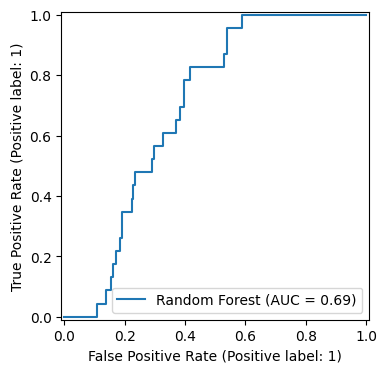

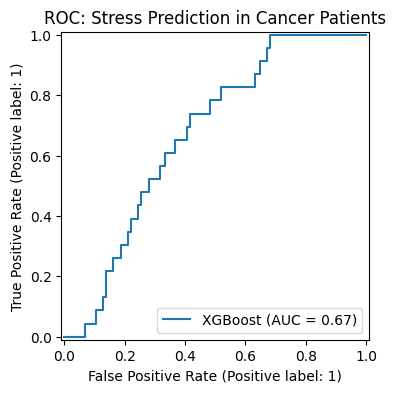

In [67]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name='Random Forest')
RocCurveDisplay.from_predictions(y_test, y_proba_xgb, name='XGBoost')
plt.title("ROC: Stress Prediction in Cancer Patients")
plt.savefig("roc_stress_models.png", dpi=200)
plt.show()


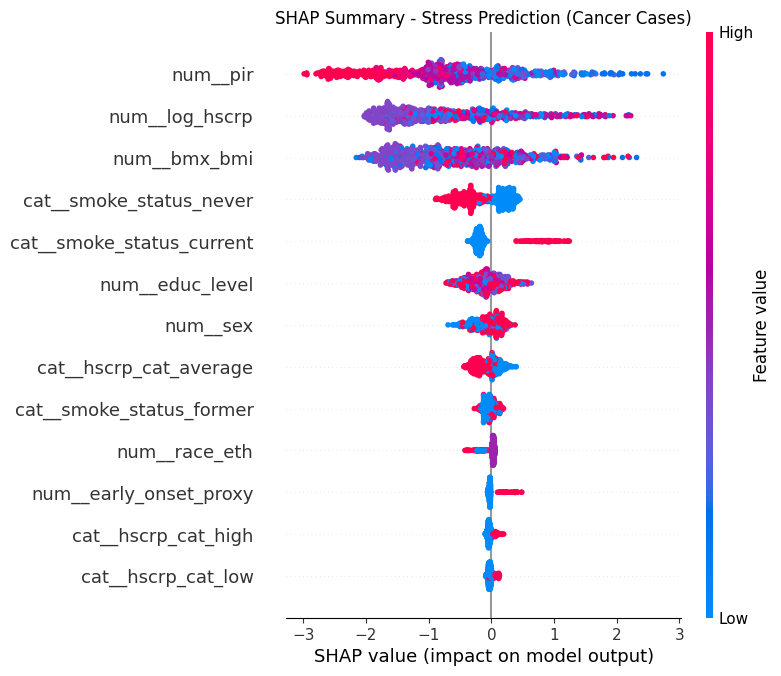

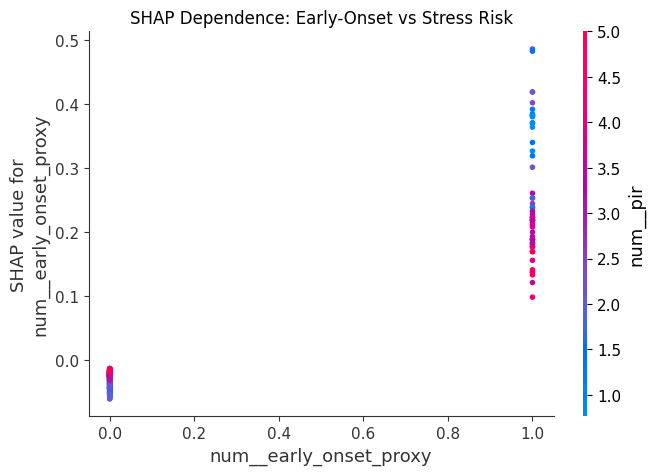

In [ ]:
enc = xgb.named_steps['pre']
clf = xgb.named_steps['clf']
X_train_enc = enc.transform(X_train)
feature_names = enc.get_feature_names_out()

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_enc)

# SHAP summary
shap.summary_plot(shap_values, X_train_enc, feature_names=feature_names, show=False)
plt.title("SHAP Summary - Stress Prediction (Cancer Cases)")
plt.savefig("shap_summary_stress.png", dpi=200)

# Dependence for early_onset_proxy
idx = list(feature_names).index('num__early_onset_proxy')
shap.dependence_plot(idx, shap_values, X_train_enc, feature_names=feature_names, show=False)
plt.title("SHAP Dependence: Early-Onset vs Stress Risk")
plt.show()


The model identified low income, high inflammation, higher BMI, and current smoking as the main drivers of stress. Early-onset cancer still contributes positively, even after accounting for these factors — meaning younger patients are more likely to have higher stress.